In [1]:
from goodfire import Client, Variant

In [2]:
client = Client(api_key="sk-goodfire-biglAsCS2oFqZU29erl8DhHbp72-6Cyi5fpbGTAfto03paEPyxNPhA")

In [3]:
variant = Variant("meta-llama/Meta-Llama-3-8B-Instruct")

In [4]:
variant70B = Variant("meta-llama/Meta-Llama-3.1-70B-Instruct")

### Filtering Features

In [ ]:
positive_examples = df[df['label'] == 'spam']
negative_examples = df[df['label'] == 'ham']

FEATURE_COMPUTE_SIZE = 50
CLASSIFIER_FULL_SET_SIZE = 150

In [ ]:
spam_features, ham_features = client.features.contrast(
    dataset_1=[
      [
          {"role": "user", "content": f"Is the following message spam or ham? {text}"},
          {"role": "assistant", "content": "spam"}
      ] for text in positive_examples[0:FEATURE_COMPUTE_SIZE]['text'].tolist()
    ],
    dataset_2=[
      [
          {"role": "user", "content": f"Is the following message spam or ham? {text}"},
          {"role": "assistant", "content": "ham"}
      ] for text in negative_examples[0:FEATURE_COMPUTE_SIZE]['text'].tolist()
    ],
    dataset_1_feature_rerank_query="spam",
    model=variant,
    top_k=50
)
features_to_look_at = spam_features | ham_features
features_to_look_at

In [ ]:
from itertools import combinations


class FeatureMixer:
  def __init__(self, feature_group):
    self.feature_group = feature_group

  def grid(self, k_features_per_combo: int =2):
    """Perform a grid search over all possible combinations of features"""

    # Get all possible combinations of features
    return list(combinations(self.feature_group, k_features_per_combo))


In [ ]:
import pandas as pd
import concurrent.futures as futures
import tqdm

def _get_feature_acts_for_sample_class(
    sample_class: pd.DataFrame,
    features_to_use_for_classification: goodfire.FeatureGroup,
    k=len(features_to_look_at),
):
  if k < len(features_to_use_for_classification):
    raise ValueError("k must be greater than the number of features to use for classification")

  samples = []
  for idx, row in tqdm.tqdm(sample_class[0:CLASSIFIER_FULL_SET_SIZE].iterrows()):
    text = row['text']
    context = client.features.inspect(
        [
            {
                "role": "user",
                "content": f"is the following good or bad for investors? {text}"
            }
        ],
        model=variant,
        features=features_to_use_for_classification,
    )

    features = context.top(k=k)
    samples.append(features)

  return samples


print("Computing spam features...")
positive_class_features = _get_feature_acts_for_sample_class(positive_examples, features_to_look_at, k=100)

print("Computing ham features...")
negative_class_features = _get_feature_acts_for_sample_class(negative_examples, features_to_look_at, k=100)


In [ ]:
from sklearn import tree
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score
import numpy as np
import tqdm


# Grid search may take a while, you can curate the feature list to speed this process up significantly
def train_tree(x, y, depth):
  train_x, test_x, train_y, test_y = train_test_split(x, y, train_size=0.5, random_state=42)

  # Create a nice regularized tree
  model = tree.DecisionTreeClassifier(
      max_depth=depth,
      min_samples_leaf=len(train_x) // 20,
      random_state=42
  )

  model.fit(train_x, train_y)

  pred = model.predict(test_x)

  # Calculate the f1 score of the model
  accuracy = balanced_accuracy_score(test_y, pred)
  score = f1_score(test_y, pred)

  return model, pred, score, accuracy


def find_best_combo(features, k_features_per_combo = 2):
  combos = FeatureMixer(features).grid(k_features_per_combo=k_features_per_combo)
  best_combo = None
  best_model = None
  best_score = 0
  best_accuracy = 0

  MAX_WORKERS = 8

  futures_list = []

  with futures.ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    for combo in combos:
      def _test_combo(combo):
        def _select_feature_acts(combo, row):
          output = []
          for index, feature in enumerate(combo):
            for feature_act in row:
              if feature_act.feature.uuid == feature.uuid:
                output.append(feature_act.activation)
                break

          return output

        x_negative = [_select_feature_acts(combo, row) for row in negative_class_features]
        x_positive = [_select_feature_acts(combo, row) for row in positive_class_features]

        y_negative = [-1] * len(x_negative)
        y_positive = [1] * len(x_positive)

        x = x_negative + x_positive
        y = y_negative + y_positive

        model, pred, score, accuracy = train_tree(x, y, depth=len(combo))

        return model, pred, score, accuracy, combo

      futures_list.append(executor.submit(_test_combo, combo))

    for future in tqdm.tqdm(futures_list):
      model, pred, score, accuracy, combo = future.result()

      if score > best_score:
        best_score = score
        best_combo = combo
        best_model = model
        best_accuracy = accuracy

  return best_combo, best_score, best_model, best_accuracy


best_combo_at_k = {}
for i in range(3):
  best_combo, best_score, best_model, best_accuracy = find_best_combo(features_to_look_at, k_features_per_combo = i + 1)
  print(i + 1, best_combo, best_score, best_accuracy, best_model)
  best_combo_at_k[i + 1] = (best_combo, best_score, best_model)


In [ ]:
# Function to visualize the decision tree
def visualize_tree(tree_model, features, class_names=['negative', 'positive']):
    import graphviz
    dot_data = tree.export_graphviz(
        tree_model,
        out_file=None,
        feature_names=[feature.label for feature in features],
        class_names=class_names,
        filled=True,
        rounded=True,
        special_characters=True
    )
    graph = graphviz.Source(dot_data)
    return graph

In [ ]:
# Anyways let's look at the best overall tree
BEST_TREE_INDEX = 3
best_features = best_combo_at_k[BEST_TREE_INDEX][0]
best_score = best_combo_at_k[BEST_TREE_INDEX][1]
best_tree = best_combo_at_k[BEST_TREE_INDEX][2]

# Visualize the tree
print(best_tree)
print(best_features)
print(best_score)
visualize_tree(best_tree, best_features)

### Bias Analysis

In [5]:
from datasets import load_dataset
import pandas as pd

ds = load_dataset("CyberNative/Code_Vulnerability_Security_DPO")

df = pd.DataFrame(ds["train"])

In [6]:
features_of_interest = ['a56cc632-1f98-4468-a1cc-47b7edab8e53', '89747292-8acc-4940-a59d-16be3fb1d665', 'faeaf4a9-8e9f-4e12-9677-c80e753cbf06', '0c4b4ffa-29ca-4eab-94ca-a66871dff2e2', '3d2b2063-05cc-4a32-9ac3-e97a467fa948', 'b795ebf8-5776-438d-986d-f8476b16eedb', '235cb931-8b2c-483f-88e4-d659109ac41b', '38ce884c-6af6-4243-b9a6-5a95db045d1b', '4ecfe1ff-948b-4f6b-83ba-47f911fbb966', 'c0aa32db-d432-4f61-956e-34ecd245e272']

feature_group = client.features.list(features_of_interest)

In [11]:
def collect_token_activations(sample):
  context = client.features.inspect(
    [
      {
        "role": "user",
        "content": sample
      }
    ],
    model=variant70B,
    features=feature_group,
  )

  tokens = [context.tokens[i]._token for i in range(len(context.tokens))]
  all_feat_acts = []
  feat_act_matrix = context.matrix()[0]
  for feat_idx in range(len(feature_group)):
    feat_acts = []
    for i in range(len(context.tokens)):
      feat_acts.append(feat_act_matrix[i][feature_group[feat_idx].index_in_sae])
    all_feat_acts.append(feat_acts)
  return tokens, all_feat_acts

In [12]:
python_df = df

sampled_df = python_df.sample(n=1000, random_state=42)

In [13]:
text_options = []
feature_activations = []

In [14]:
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import time

def process_sample(sample):
    chosen_tokens, chosen_acts = collect_token_activations(f"Is the following code vulnerable or safe? {sample['chosen']}")
    reject_tokens, reject_acts = collect_token_activations(f"Is the following code vulnerable or safe? {sample['rejected']}")
    text_options.append([chosen_tokens, reject_tokens])
    feature_activations.append([chosen_acts, reject_acts])

def process_with_backoff(sample):
    max_retries = 5
    backoff_factor = 2
    for attempt in range(max_retries):
        try:
            process_sample(sample)
            break
        except:
            if attempt < max_retries - 1:
                sleep_time = backoff_factor ** attempt
                time.sleep(sleep_time)
            else:
                raise

with ThreadPoolExecutor(max_workers=8) as executor:
    list(tqdm(executor.map(process_with_backoff, [sample for _, sample in sampled_df.iterrows()]), total=len(sampled_df), desc="Processing samples"))


Processing samples: 100%|██████████| 1000/1000 [08:06<00:00,  2.05it/s]


### Dimensionality Reduction

In [26]:
dim_reduce = []
for sample in feature_activations:
  dim_reduce.append([
    [np.array(sample[0][feat_idx]).max() for feat_idx in range(len(feature_group))],
    [np.array(sample[1][feat_idx]).max() for feat_idx in range(len(feature_group))]
  ])

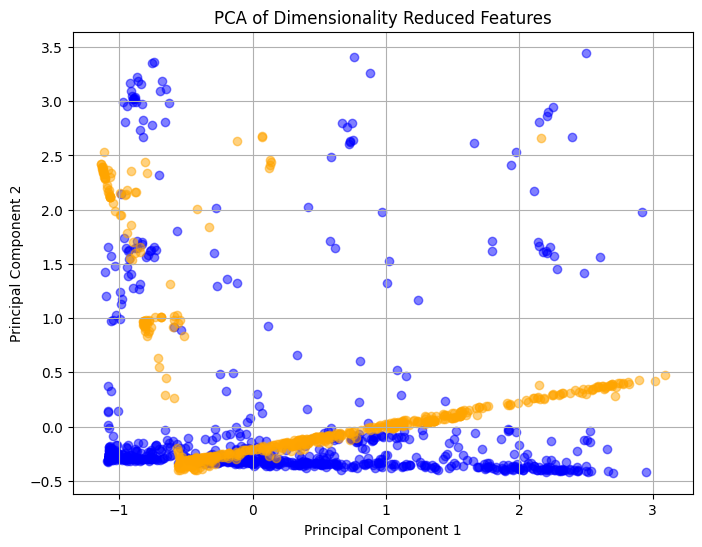

In [27]:
from sklearn.decomposition import PCA
import numpy as np

# Convert dim_reduce to a numpy array for PCA
dim_reduce_array = np.array(dim_reduce)

# Apply PCA
pca = PCA(n_components=2)
pca_result1 = pca.fit_transform(dim_reduce_array[:, 0]) # chosen
pca_result2 = pca.fit_transform(dim_reduce_array[:, 1]) # rejected

# Plot the PCA results
plt.figure(figsize=(8, 6))
plt.scatter(pca_result1[:, 0], pca_result1[:, 1], color='blue', alpha=0.5, label='Chosen')
plt.scatter(pca_result2[:, 0], pca_result2[:, 1], color='orange', alpha=0.5, label='Rejected')
plt.title('PCA of Dimensionality Reduced Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


### Distributions between datasets

In [18]:
num_features = len(feature_activations[0][0])

feature_to_dist = dict()
for feat_idx in range(num_features):
  feature_to_dist[feature_group[feat_idx].label] = [
    [np.array(sample[0][feat_idx]).max() for sample in feature_activations],
    [np.array(sample[1][feat_idx]).max() for sample in feature_activations],
  ]

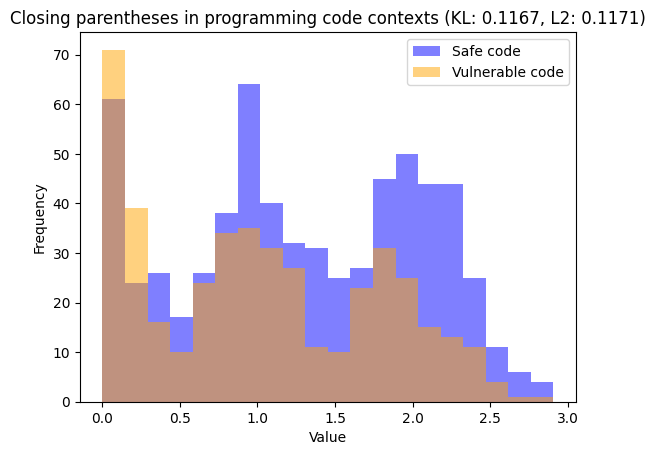

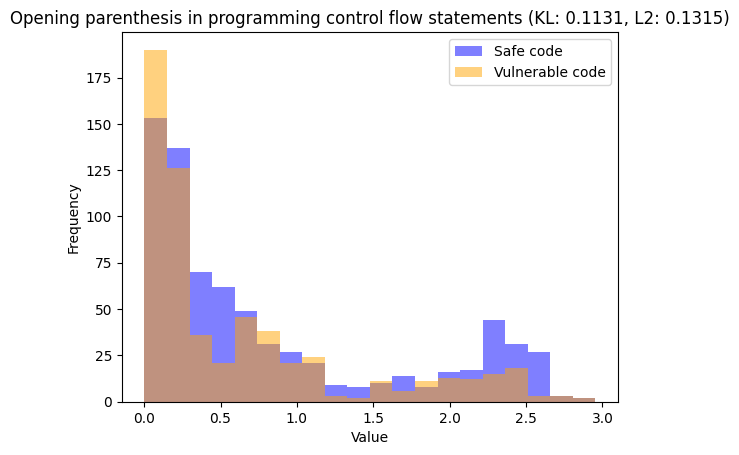

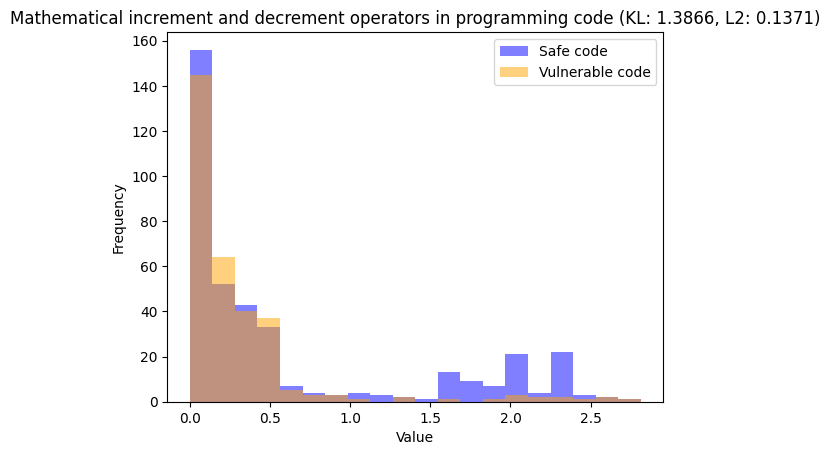

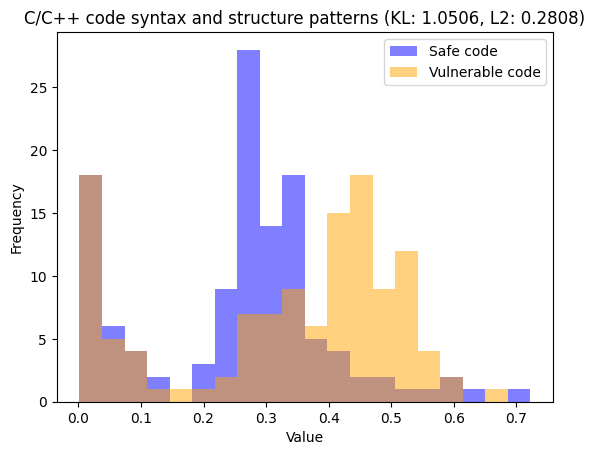

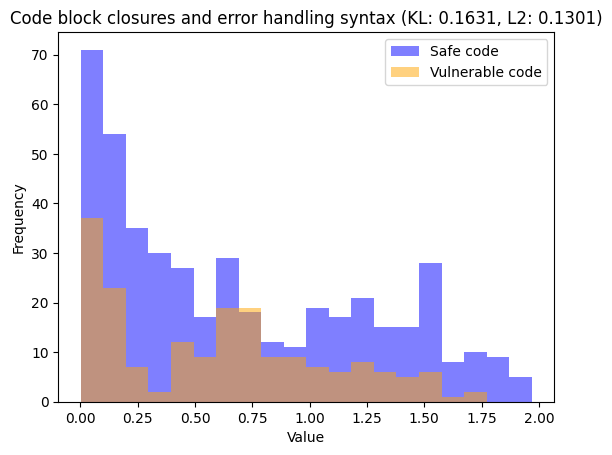

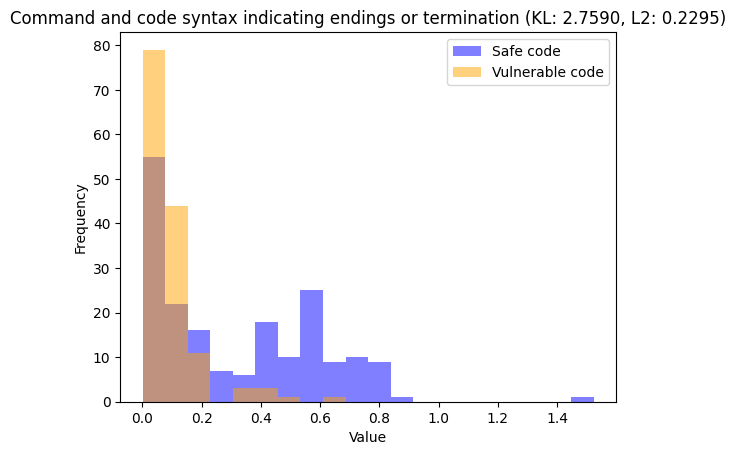

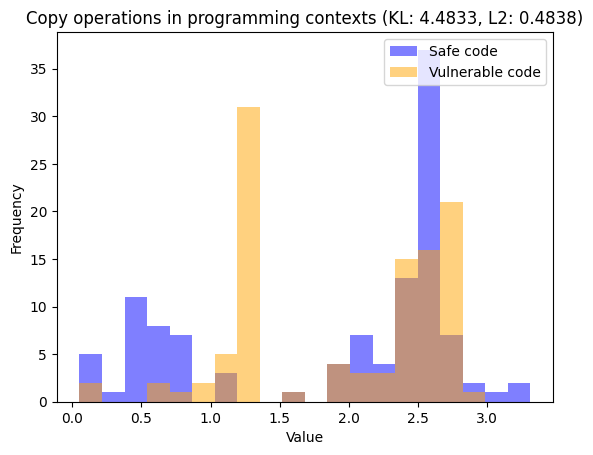

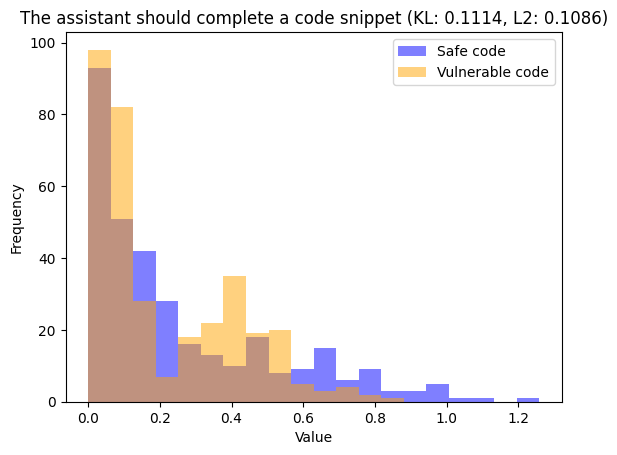

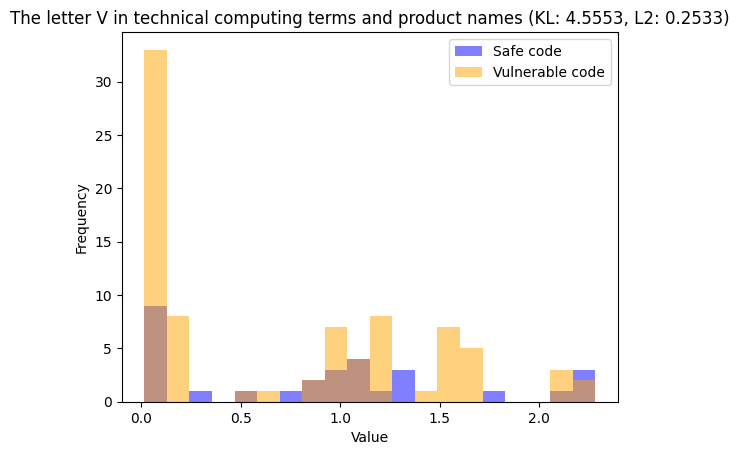

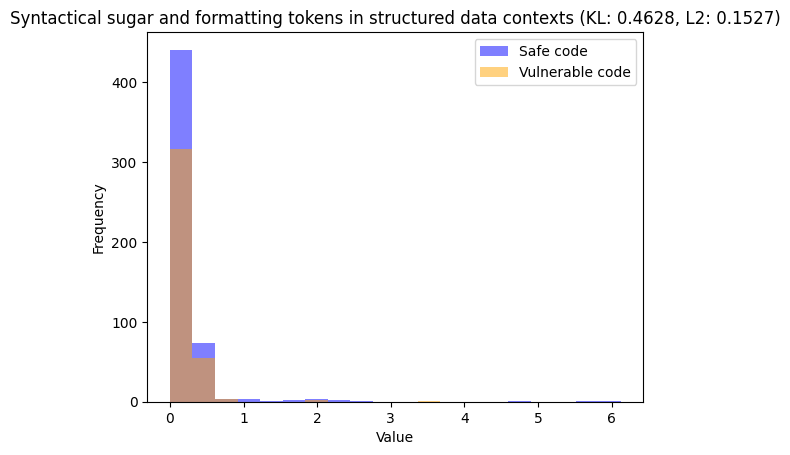

In [23]:
import matplotlib.pyplot as plt

from scipy.stats import entropy

epsilon = 1e-10
dist_metrics = []

for title, distributions in feature_to_dist.items():
    distributions[0] = [value for value in distributions[0] if value != 0]
    distributions[1] = [value for value in distributions[1] if value != 0]
    # Compute histograms
    hist_safe, bin_edges = np.histogram(np.array(distributions[0]), bins=20, density=True)
    hist_vulnerable, _ = np.histogram(np.array(distributions[1]), bins=20, density=True)

    # Compute KL divergence
    dist0 = np.array(hist_safe) + epsilon
    dist1 = np.array(hist_vulnerable) + epsilon
    dist0 = dist0 / np.sum(dist0)
    dist1 = dist1 / np.sum(dist1)
    kl_divergence = entropy(dist0, dist1)
    l2_distance = np.linalg.norm(dist0 - dist1)
    dist_metrics.append([title, kl_divergence, l2_distance])

    # Plot histograms
    plt.figure()
    plt.title(f"{title} (KL: {kl_divergence:.4f}, L2: {l2_distance:.4f})")
    plt.hist(distributions[0], bins=bin_edges, color='blue', alpha=0.5, label='Safe code')
    plt.hist(distributions[1], bins=bin_edges, color='orange', alpha=0.5, label='Vulnerable code')
    plt.legend(loc='upper right')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()

In [24]:
dist_metrics

[['Closing parentheses in programming code contexts',
  0.11666967476632861,
  0.11713532101219867],
 ['Opening parenthesis in programming control flow statements',
  0.11310199236584711,
  0.13151215437310884],
 ['Mathematical increment and decrement operators in programming code',
  1.3866265274624807,
  0.13712576991872164],
 ['C/C++ code syntax and structure patterns',
  1.050600060921438,
  0.2808493907953379],
 ['Code block closures and error handling syntax',
  0.16314490886235733,
  0.13013348521686885],
 ['Command and code syntax indicating endings or termination',
  2.758979738546796,
  0.22950631260030532],
 ['Copy operations in programming contexts',
  4.483260811275982,
  0.48376233457166745],
 ['The assistant should complete a code snippet',
  0.11140464186528613,
  0.10861092863305036],
 ['The letter V in technical computing terms and product names',
  4.555337391455353,
  0.25325258220969993],
 ['Syntactical sugar and formatting tokens in structured data contexts',
  0.

### Interface

In [25]:
import ipywidgets as widgets
from IPython.display import display, HTML
import numpy as np

current_option = 0
current_feat = 0

# Dropdown to select text
dropdown = widgets.Dropdown(
    options=[i for i in range(len(text_options))],
    value=current_option,
    description='Select Text:',
)

# Function to update displayed text
def update_text(change):
    global current_option
    current_option = int(change["new"])
    new_chosen_text_area = ""
    new_rejected_text_area = ""
    chosen_feat_acts = np.array(feature_activations[current_option][0][current_feat])
    rejected_feat_acts = np.array(feature_activations[current_option][1][current_feat])
    chosen_feat_acts = chosen_feat_acts / max(chosen_feat_acts) if max(chosen_feat_acts) > 0 else chosen_feat_acts
    rejected_feat_acts = rejected_feat_acts / max(rejected_feat_acts) if max(rejected_feat_acts) > 0 else rejected_feat_acts
    # print(current_option)
    # print(text_options[current_option][0])
    for i in range(len(text_options[current_option][0])):
        new_chosen_text_area += f"<span style='background-color: rgba(0, 255, 255, {chosen_feat_acts[i]});'>{text_options[current_option][0][i]}</span>"
    for j in range(len(text_options[current_option][1])):
        new_rejected_text_area += f"<span style='background-color: rgba(0, 255, 255, {rejected_feat_acts[j]});'>{text_options[current_option][1][j]}</span>"
    chosen_text_area.value = new_chosen_text_area
    rejected_text_area.value = new_rejected_text_area

feature_text_area = widgets.HTML(
    value=f"<div>{feature_group[0].label}</div>",
    description='Feature description:',
    layout=widgets.Layout(width='100%', height='50px')  # Increased height
)

# Text areas to display the selected text
chosen_text_area = widgets.HTML(
    value=f"<div>{"".join(text_options[current_option][0])}</div>",
    description='Chosen Text:',
    layout=widgets.Layout(width='100%', height='300px')  # Increased height
)

rejected_text_area = widgets.HTML(
    value=f"<div>{"".join(text_options[current_option][1])}</div>",
    description='Rejected Text:',
    layout=widgets.Layout(width='100%', height='300px')  # Increased height
)

def highlight_feature(feat_num):
    global current_feat
    current_feat = feat_num
    new_chosen_text_area = ""
    new_rejected_text_area = ""
    chosen_feat_acts = np.array(feature_activations[current_option][0][feat_num])
    rejected_feat_acts = np.array(feature_activations[current_option][1][feat_num])
    chosen_feat_acts = chosen_feat_acts / max(chosen_feat_acts) if max(chosen_feat_acts) > 0 else chosen_feat_acts
    rejected_feat_acts = rejected_feat_acts / max(rejected_feat_acts) if max(rejected_feat_acts) > 0 else rejected_feat_acts
    # print(current_option)
    # print(text_options[current_option][0])
    for i in range(len(text_options[current_option][0])):
        new_chosen_text_area += f"<span style='background-color: rgba(0, 255, 255, {chosen_feat_acts[i]});'>{text_options[current_option][0][i]}</span>"
    for j in range(len(text_options[current_option][1])):
        new_rejected_text_area += f"<span style='background-color: rgba(0, 255, 255, {rejected_feat_acts[j]});'>{text_options[current_option][1][j]}</span>"
    chosen_text_area.value = new_chosen_text_area
    rejected_text_area.value = new_rejected_text_area
    feature_text_area.value = feature_group[feat_num].label

# Dropdown to select feature activation
feature_dropdown = widgets.Dropdown(
    options=[j for j in range(len(feature_activations[0][0]))],
    value=current_feat,
    description='Select Feature:',
)

# Assign dropdown change event
feature_dropdown.observe(lambda change: highlight_feature(change['new']), names='value')

# Update text when dropdown value changes
dropdown.observe(update_text, names='value')

# Display the interface
display(widgets.HBox([dropdown, feature_dropdown]))
display(widgets.VBox([feature_text_area, chosen_text_area, rejected_text_area]))